In [235]:
import pandas as pd
from xgboost import XGBClassifier
import numpy as np

In [236]:
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [237]:
from sklearn.metrics import accuracy_score

In [238]:
import pickle
import re
import joblib
import fitz

In [239]:
count_vec = joblib.load("vectorizer/vectorizer.pkl")
tfizer = joblib.load("vectorizer/tfidf_vectorizer.pkl")

In [240]:
count_vec.vocabulary_

{'moment': 574,
 'play': 667,
 'life': 513,
 'change': 128,
 'experience': 301,
 'today': 902,
 'perc': 646,
 'thing': 890,
 'friend': 360,
 'post': 679,
 'facebook': 312,
 'day': 209,
 'rest': 744,
 'hello': 416,
 'sorry': 814,
 'hear': 413,
 'natural': 587,
 'relationship': 733,
 'time': 898,
 'try': 919,
 'figure': 338,
 'hard': 406,
 'welcome': 967,
 'stuff': 853,
 'game': 371,
 'set': 774,
 'match': 551,
 'minute': 569,
 'move': 582,
 'don': 252,
 'mean': 556,
 'sit': 793,
 'maybe': 554,
 'healthy': 412,
 'basically': 75,
 'come': 152,
 've': 940,
 'determine': 232,
 'type': 922,
 'want': 954,
 'likely': 516,
 'use': 935,
 'give': 380,
 'cognitive': 148,
 'function': 367,
 'leave': 508,
 'video': 943,
 'good': 385,
 'note': 608,
 'somewhat': 811,
 'completely': 162,
 'death': 213,
 'dear': 212,
 'favorite': 326,
 'grow': 391,
 'current': 200,
 'cool': 183,
 'appear': 40,
 'late': 499,
 'sad': 753,
 'wait': 949,
 'think': 891,
 'confidence': 169,
 'inner': 458,
 'world': 983,
 'enj

In [241]:
b_pres_reverse = [
  {0: 'I', 1: 'E'},
  {0: 'N', 1: 'S'},
  {0: 'T', 1: 'F'},
  {0: 'J', 1: 'P'}
]

In [242]:
model = pickle.load(open("model/model.pkl", "rb"))

In [243]:
def translate_back(personality):
  s = ""
  for i, j in enumerate(personality):
    s += b_pres_reverse[i][j]
  return s

In [11]:
!python -m spacy download en

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 2.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for en_core_web_sm: filename=en_core_web_sm-2.2.5-py3-none-any.whl size=12011737 sha256=65aa68f965a92c8503d01f48ffef5cf082ddf8990af03d1ae3675c1ea6db1650
  Stored in directory: /private/var/folders/fs/cxxsbdls25bd02mzl1rc7sw40000gn/T/pip-ephem-wheel-cache-g7nfbz3l/wheels/51/19/da/a3885266a3c241aff0ad2eb674ae058fd34a4870fef1c0a5a0
Successfully built en_core_web_sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/Users/aayam/project/personality-analysis-model/venv/lib/python3.7/site-packages/en_core_web_sm
-->
/Users/aayam/project/personality-analysis-model/venv/lib/python3.7/site-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [9]:
# pers_types = [
#     'INFP' ,'INFJ', 'INTP', 'INTJ', 'ENTP', 
#     'ENFP', 'ISTP' ,'ISFP' ,'ENTJ', 'ISTJ',
#     'ENFJ', 'ISFJ' ,'ESTP', 'ESFP' ,'ESFJ' ,'ESTJ']

In [10]:
# type_list = [x.lower() for x in pers_types]

In [244]:
nlp = spacy.load('en', disable = ['parse', 'ner'])

def  pre_process(data):
  list_posts = []

  for row in data.iterrows():
    posts = row[1].posts

    # remove url
    temp = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', ' ', posts)

    # remove non-words
    temp = re.sub(r'[^A-Za-z]', " ", temp)

    #remove more than one space
    temp = re.sub(' +', " ", temp).lower()

    #remove multiple letter repeating words
    temp = re.sub(r'([a-z])\1{2,}[\s|\w]*', '', temp)

    #remove stop words
    doc = nlp(temp)
    temp = " ".join([tok.lemma_ for tok in doc if not tok.is_stop])

    list_posts.append(temp)

  list_posts = np.array(list_posts)
  return list_posts

In [245]:
test_resumes_dir = "test_resume"

In [246]:
import os

test_resumes_files = [os.path.join(test_resumes_dir, f) 
                      for f in os.listdir(test_resumes_dir) 
                      if f.endswith(".pdf")]

In [247]:
test_resumes_files

['test_resume/Aayam_Ojha_CV.pdf', 'test_resume/cv.pdf']

In [248]:
my_posts = []
for fname in test_resumes_files:
    doc = fitz.open(fname)
    text = ""
    for page in doc:
      text += str(page.get_text())
    
    my_posts.append(text)

my_posts = [t.replace('\n', ' ').strip() for t in my_posts]
my_data = pd.DataFrame(data={'type': 'INFJ', 'posts': my_posts})
my_posts = pre_process(my_data)

In [249]:
my_X_cnt = count_vec.transform(my_posts)

In [250]:
my_X_tfidf = tfizer.transform(my_X_cnt).toarray()

In [251]:
result = {}
probs = {}
for fname, x_tfidf in zip([i.split("/")[1] 
                              for i in test_resumes_files], 
                      my_X_tfidf):
    pred_result = []
    prob_result = []
    for i in model:
      y_pred = i.predict([x_tfidf])
      y_pred_prob = i.predict_proba([x_tfidf])
        
      pred_result.append(y_pred[0])
      prob_result.append(y_pred_prob[0] * 100)    
    
    result[fname] = pred_result
    probs[fname] = prob_result

In [252]:
for key in result:
    print(result[key])

[0, 0, 0, 1]
[0, 0, 1, 0]


In [253]:
actual_personality = {
    'I': "Introvert",
    'E': "Extrovert",
    'N': "Intution",
    'S': "Sensing",
    "T": "Thinking",
    'F': "Felling",
    "J": "Judging",
    "P": "Perceiving"
}

In [254]:
pd_structure = {"name" :pd.Series([], dtype=pd.StringDtype())}
pd_structure.update({value: pd.Series([])  for value in actual_personality.values()})
pd_structure.update({"personality_cat": pd.Series([], dtype=pd.StringDtype())})
data_result = pd.DataFrame().from_dict(pd_structure)

/Users/aayam/project/personality-analysis-model/venv/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  



In [255]:
data_result.dtypes

name                string
Introvert          float64
Extrovert          float64
Intution           float64
Sensing            float64
Thinking           float64
Felling            float64
Judging            float64
Perceiving         float64
personality_cat     string
dtype: object

In [256]:
for key in result:
    temp = []
    personality_ = translate_back(result[key])
    probs_ = list(np.concatenate(probs[key]).flat)
    temp.append(key)
    temp += probs_
    temp.append(personality_)
    data_result.loc[len(data_result)] = temp

In [257]:
data_result

,name,Introvert,Extrovert,Intution,Sensing,Thinking,Felling,Judging,Perceiving,personality_cat
0,Aayam_Ojha_CV.pdf,79.365662,20.634335,80.254608,19.745392,53.579891,46.420113,37.091385,62.908615,INTP
1,cv.pdf,85.042587,14.957409,85.257828,14.742170,33.713852,66.286148,56.728214,43.271786,INFJ


In [258]:
import matplotlib.pyplot as plt

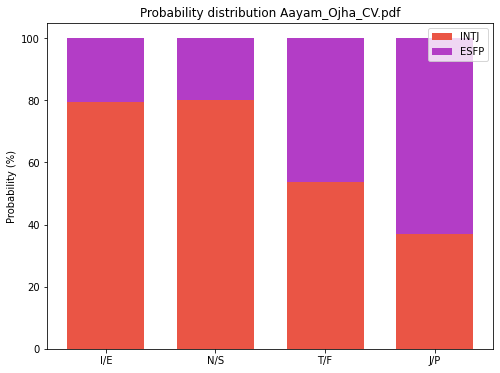

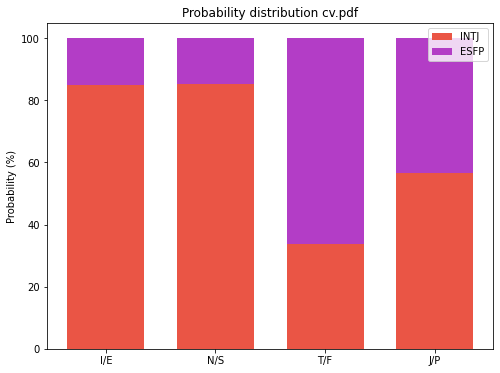

In [270]:
N = 4
ind = np.arange(N)
width = 0.7
for data in data_result.iterrows():
    data = data[1]
    bottom = (data["Introvert"], 
        data["Intution"], 
        data["Thinking"], data["Judging"])
    top = (data["Extrovert"], data["Sensing"],
          data["Felling"], data["Perceiving"])
    plt.figure(figsize=(8, 6))
    p1 = plt.bar(ind, bottom, width, 
                 label="INTJ", color="#ea5545")
    p2 = plt.bar(ind, top, width, bottom=bottom, label="ESFP", color="#b33dc6")


    plt.ylabel("Probability (%)")
    plt.title(f"Probability distribution {data['name']}")
    plt.xticks(ind, ('I/E',  'N/S', 'T/F', 'J/P',))
    plt.legend()
    plt.show()